##  Imports and Setup

In [2]:
import os
import warnings
from os import path

# Suppress warnings for cleaner outputs
warnings.filterwarnings("ignore")

# Path to data directory
DATA_PATH = "./grape"

# Set the working directory
os.chdir(DATA_PATH)

import grape  # Grammatical evolution library

# Path to grammar file
GRAMMAR_FILE = "grover.bnf"
BNF_GRAMMAR_PATH = path.join("grammars", GRAMMAR_FILE)
BNF_GRAMMAR = grape.Grammar(BNF_GRAMMAR_PATH)
import algorithms  # Evolutionary algorithms


In [3]:
from qiskit import QuantumCircuit, transpile  
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram 
import numpy as np
import grape
# import algorithms
import matplotlib.pyplot as plt
from IPython.display import display
from deap import creator, base, tools
import math
import pandas as pd
import re
from typing import Any, Tuple

# Grammatical Evolution

## Fitness Function

In [4]:
# ----------------------------------------------------------
# Helper: Generate Oracle Code for a Given Marked State
# ----------------------------------------------------------
def generate_oracle_code(marked_state):
    """
    Generate a code snippet (as a string) implementing an oracle that flips the phase 
    of the amplitude for the target marked state.
    """
    n = len(marked_state)
    code_lines = []
    # For each qubit, if the target bit is '0', apply an X gate.
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    # Apply a Hadamard to the last qubit, then a multi-controlled X gate (mcx),
    # then Hadamard again to flip the phase.
    code_lines.append(f"qc.h({n-1})")
    code_lines.append(f"qc.mcx(list(range({n-1})), {n-1})")
    code_lines.append(f"qc.h({n-1})")
    # Undo the earlier X gates.
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    return "\n".join(code_lines) + "\n"

In [5]:
# ----------------------------------------------------------
# Helper: Replace Oracle Block in the Phenotype String
# ----------------------------------------------------------
def replace_oracle_block(phenotype_str, new_oracle_code):
    """
    Replace the code between "## Begin Oracle" and "## End Oracle" in the phenotype string 
    with new_oracle_code.
    """
    pattern = r"(## Begin Oracle\n)(.*?)(## End Oracle\n)"
    new_block = r"\1" + new_oracle_code + r"\3"
    return re.sub(pattern, new_block, phenotype_str, flags=re.DOTALL)


In [6]:
def fitness_function(phenotype_str, shots=512, threshold=0.48, 
                     zero_prob_penalty=20.0, gate_penalty_weight=0.01):
    """
    Evaluates an evolved Grover circuit (as a phenotype string) over all possible marked states.
    
    For each possible state (e.g. for 3 qubits: '000' ... '111'):
      1. Replace the oracle block with an oracle tailored for that marked state.
      2. Execute the modified phenotype string to obtain a circuit.
      3. Simulate the circuit and compute the probability for the target state.
      4. If the probability is below a given threshold, count it as a "miss".
      5. Also accumulate error metrics (1 - probability) and record the circuit size.
    
    The final fitness score is computed (lower is better) as a weighted combination of:
      - Number of misses (e.g. 10×misses)
      - Maximum and average error (across all states)
      - A gate-count penalty, and optionally a fixed zero-probability penalty if any test fails.
    
    Adjust the weights and threshold as needed.
    """
    # Assume we are working with 3-qubit circuits.
    num_qubits = 3
    all_states = [format(i, f"0{num_qubits}b") for i in range(2**num_qubits)]
    
    total_misses = 0
    accumulated_error = 0.0
    max_error = 0.0
    gate_counts = []
    simulator = QasmSimulator()
    
    # Loop over every possible marked state.
    for marked_state in all_states:
        # Generate oracle code for this marked state.
        new_oracle = generate_oracle_code(marked_state)
        # Replace the oracle block in the phenotype.
        modified_phenotype = replace_oracle_block(phenotype_str, new_oracle)
        
        # Execute the modified code to create a circuit.
        local_vars = {}
        try:
            exec(modified_phenotype, globals(), local_vars)
        except Exception as e:
            print(f"Execution error for marked state {marked_state}: {e}")
            continue
        if "qc" not in local_vars:
            continue
        circuit = local_vars["qc"]
        
        # Compile and simulate the circuit.
        compiled_circuit = transpile(circuit, simulator, optimization_level=0)
        result = simulator.run(compiled_circuit, shots=shots).result()
        counts = result.get_counts()
        # Reverse the bitstrings if needed (to match q0,q1,... ordering).
        corrected_counts = {k[::-1]: v for k, v in counts.items()}
        total_shots = sum(corrected_counts.values())
        
        # Calculate the probability for the current marked state.
        p_marked = corrected_counts.get(marked_state, 0) / total_shots if total_shots > 0 else 0.0
        error = 1 - p_marked
        accumulated_error += error
        max_error = max(max_error, error)
        if p_marked < threshold:
            total_misses += 1
        
        gate_counts.append(compiled_circuit.size())
    
    avg_error = accumulated_error / len(all_states)
    avg_gate_count = np.mean(gate_counts) if gate_counts else 0
    gate_penalty = gate_penalty_weight * avg_gate_count
    # If there were any misses (i.e. low probability for a marked state), add a fixed penalty.
    zero_prob_penalty_term = zero_prob_penalty if total_misses > 0 else 0.0
    
    # Combine metrics into a fitness score.
    # For example: fitness = 10 * (number of misses) + max_error + avg_error + gate penalty + fixed penalty.
    fitness_score = 10 * total_misses + max_error + avg_error + gate_penalty + zero_prob_penalty_term
    return fitness_score

## Decode Individual

In [7]:
def decode_individual(ind):
    """
    Decodes the individual's genome into a phenotype code string.
    Returns:
        A string containing the code if decoding is successful,
        or None if invalid.
    """
    if ind.invalid or not hasattr(ind, 'phenotype'):
        return None

    try:
        # Ensure the phenotype is a single string.
        phenotype_code = ind.phenotype
        if isinstance(phenotype_code, list):
            phenotype_code = "".join(phenotype_code)

        # Clean the phenotype using regex.
        cleaned_code = re.sub(r'\\n', '\n', phenotype_code)  # Replace literal \n with newlines
        cleaned_code = re.sub(r'^"|"$', '', cleaned_code)       # Remove leading/trailing quotes
        cleaned_code = re.sub(r'"\s+"', '\n', cleaned_code)      # Replace isolated quotes with newlines

        return cleaned_code
    except Exception as ex:
        print(f"[Decode Error] {ex}")
        return None

##  GE Initialization

In [8]:
# Define GE parameters
POPULATION_SIZE    = 25000
MAX_GENERATIONS    = 100
P_CROSSOVER        = 0.8     
P_MUTATION         = 0.01
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 400
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 5
MIN_INIT_DEPTH     = 9        
MAX_INIT_DEPTH     = 20       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION='list'
REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'fitness_test',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

In [9]:
# Create fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

# Initialize toolbox
toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,  
    max_init_depth=MAX_INIT_DEPTH,  
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)


## Evaluate Function

In [10]:


def evaluate(individual: Any, points_train=None) -> Tuple[float]:
    """
    Evaluate an individual by decoding its phenotype (a code string) into a quantum circuit
    and computing its fitness by testing its performance across all possible marked states.
    
    If decoding fails, returns (infinity,).
    """
    try:
        # decode_individual should return the phenotype string.
        phenotype_str = decode_individual(individual)
    except Exception as e:
        print(f"[Decoding Error] {e}")
        return (float('inf'),)
    
    if not phenotype_str:
        return (float('inf'),)
    
    fitness_val = fitness_function(phenotype_str)
    return (fitness_val,)
toolbox.register("evaluate", evaluate)


In [11]:
population = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_DEPTH,
                                      max_init_depth=MAX_INIT_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                       )
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# Prepare statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Run the GE evolutionary algorithm with elitism
population, logbook = algorithms.ge_eaSimpleWithElitism(
    population,
    toolbox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    elite_size=ELITE_SIZE,
    bnf_grammar=BNF_GRAMMAR,
    codon_size=CODON_SIZE,
    max_tree_depth=MAX_TREE_DEPTH,
    max_genome_length=None,
    codon_consumption=CODON_CONSUMPTION,
    report_items=["gen", "min", "max", "avg", "std"],
    genome_representation="list",
    stats=stats,
    halloffame=hof,
    verbose=False
)

gen = 0 , Best fitness = (np.float64(51.878173828125),)
gen = 1 , Best fitness = (np.float64(41.219052734375),) , Number of invalids = 4892
gen = 2 , Best fitness = (np.float64(41.219052734375),) , Number of invalids = 2943
gen = 3 , Best fitness = (np.float64(1.2307421875),) , Number of invalids = 2015
gen = 4 , Best fitness = (np.float64(1.2307421875),) , Number of invalids = 1437
gen = 5 , Best fitness = (np.float64(1.2307421875),) , Number of invalids = 1197
gen = 6 , Best fitness = (np.float64(1.20095703125),) , Number of invalids = 989
gen = 7 , Best fitness = (np.float64(1.20095703125),) , Number of invalids = 892
gen = 8 , Best fitness = (np.float64(1.182431640625),) , Number of invalids = 754
gen = 9 , Best fitness = (np.float64(1.163154296875),) , Number of invalids = 600
gen = 10 , Best fitness = (np.float64(1.163154296875),) , Number of invalids = 523
gen = 11 , Best fitness = (np.float64(1.163154296875),) , Number of invalids = 482
gen = 12 , Best fitness = (np.float64(1.1

In [12]:
def code_to_circuit(phenotype_code):
    """
    Executes the phenotype code (a string) to create a QuantumCircuit.
    Returns the circuit (assumed to be stored in the variable 'qc') if successful,
    or None otherwise.
    """
    local_vars = {}
    try:
        exec(phenotype_code, globals(), local_vars)
        if "qc" in local_vars:
            return local_vars["qc"]
        else:
            print("No circuit variable 'qc' found in phenotype code.")
            return None
    except Exception as e:
        print(f"Error executing phenotype code: {e}")
        return None


[HALL OF FAME]
Individual 1:
Genome: [51, 61, 119, 357, 246, 373, 347, 342, 381, 370, 156, 64, 253, 113, 153, 153, 381, 273, 203, 27, 276, 191, 222, 92, 159, 57, 359, 319, 43, 288, 149, 330, 371, 237, 264, 295, 347, 165, 357, 246, 367, 275, 264, 323, 315, 49, 106, 141, 145, 79, 346, 91, 42, 397, 280, 220, 327, 3, 152, 281, 281, 281, 371, 391, 153, 282, 111, 24, 379, 359, 39, 40, 64, 375, 16, 328, 319, 291, 105, 157, 382, 165, 208, 261, 61, 119, 44, 117, 95, 67, 262, 370, 332, 215, 375, 137, 101, 119, 44, 117, 95, 243, 137, 101, 359, 236, 273, 203, 188, 276, 239, 94, 9, 68, 106, 53, 248, 289, 208, 231, 61, 119, 44, 117, 95, 243, 137, 101, 359, 373, 273, 203, 27, 396, 25, 278, 179, 137, 220, 9, 208, 231, 316, 49, 396, 147, 400, 359, 319, 0, 316, 49, 106, 13, 248, 289, 208, 231, 61, 119, 44, 117, 95, 339, 137, 101, 359, 373, 273, 282, 27, 276, 191, 222, 180, 385, 383, 105, 157, 382, 275, 264, 222, 373, 330, 8, 316, 287, 363, 97, 295, 124, 254, 29, 240, 3, 326, 281, 371, 291, 105, 157, 38

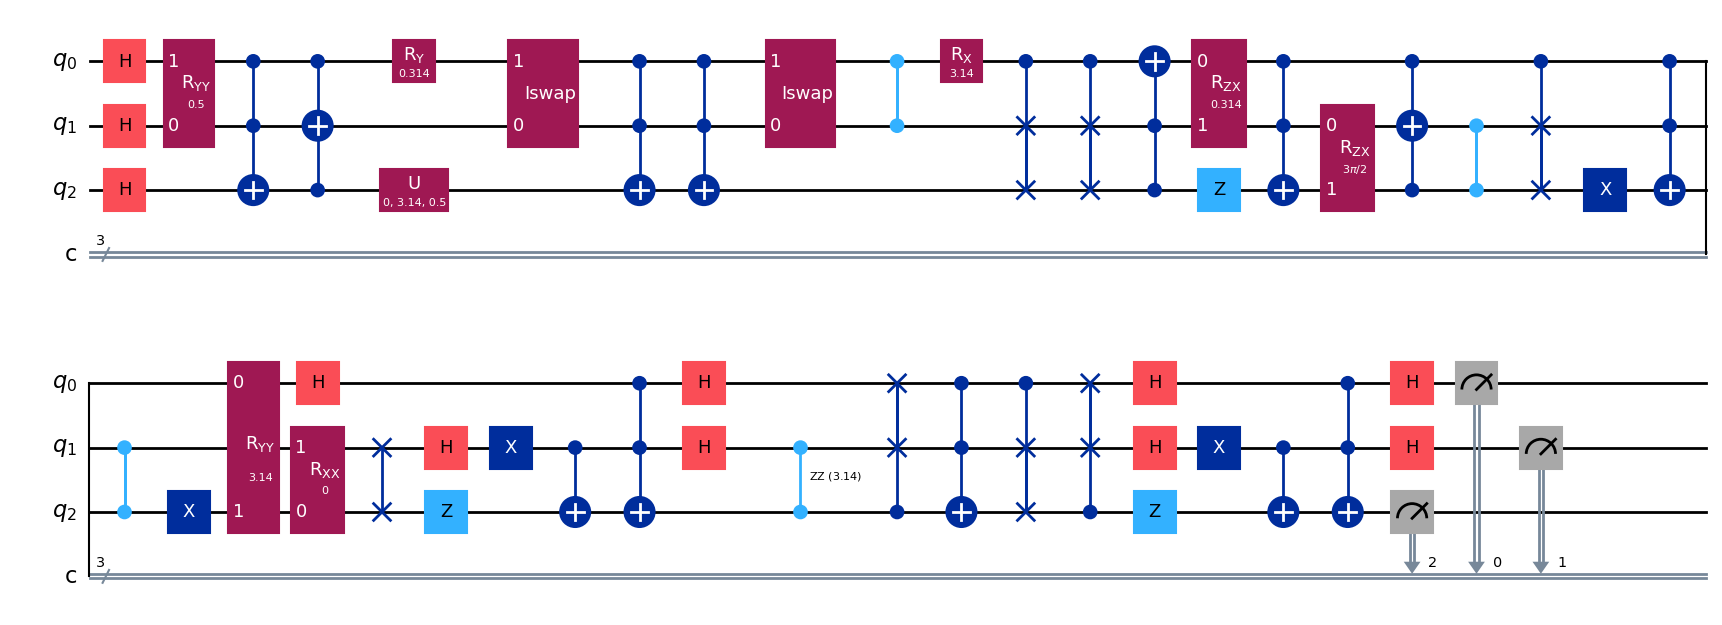


Best Individual's Fitness: 0.45473632812500003


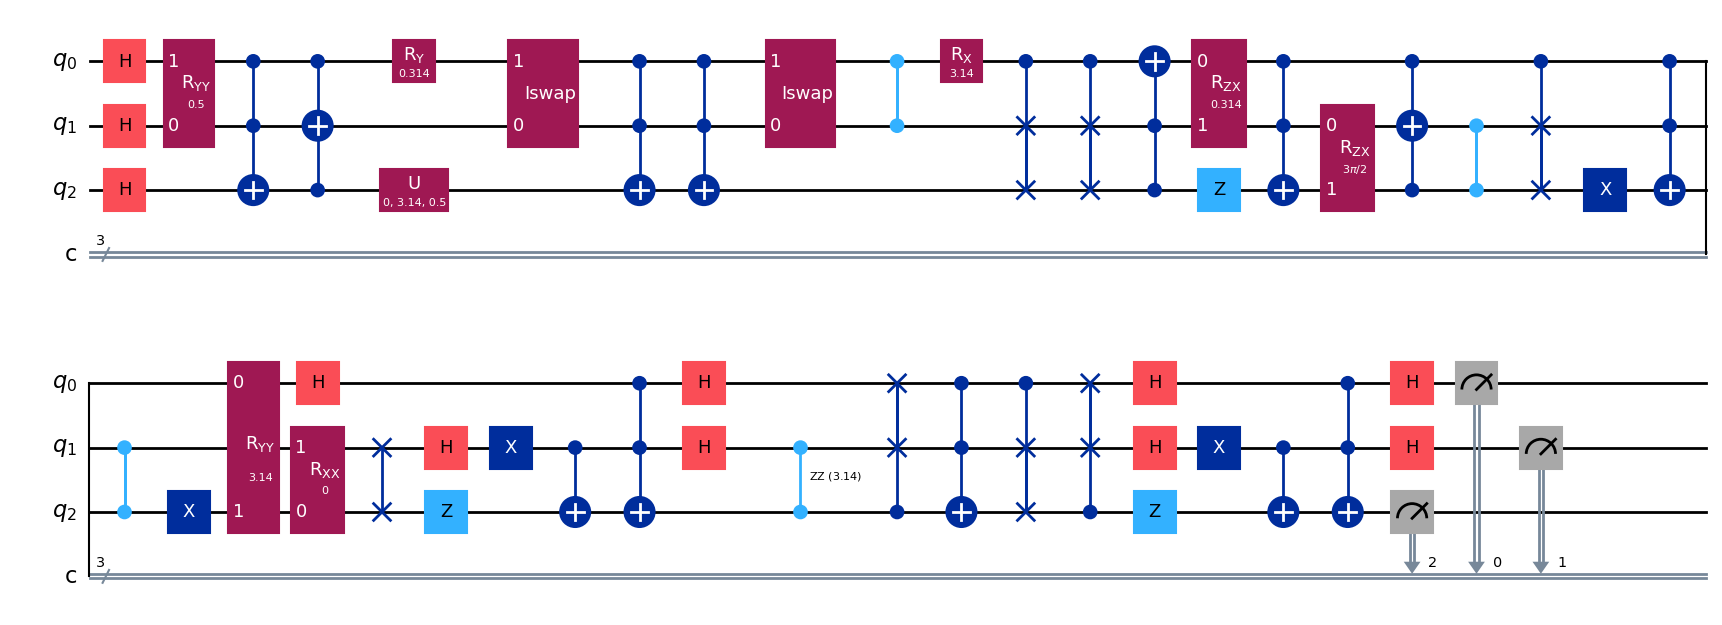


Final Measurement Counts: {'010': 23, '000': 29, '001': 113, '011': 64, '100': 139, '111': 22, '110': 60, '101': 62}


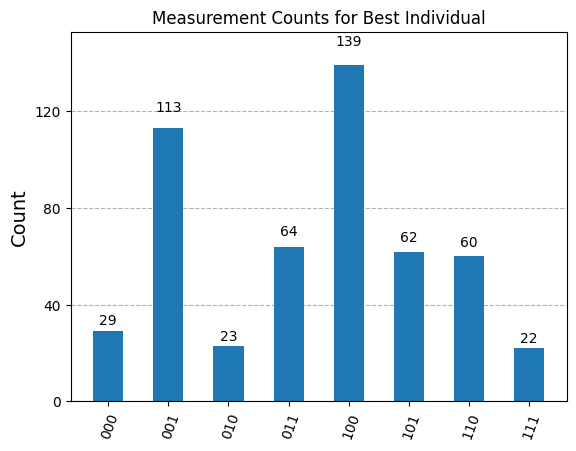

In [13]:
print("\n[HALL OF FAME]")
for i, hof_ind in enumerate(hof.items):
    print(f"Individual {i+1}:")
    print(f"Genome: {hof_ind.genome}")
    print(f"Phenotype: {hof_ind.phenotype}")
    print(f"Fitness: {hof_ind.fitness.values[0]}")

# Decode and display the best circuit from the Hall of Fame
best_ind = hof.items[0]
# Get the phenotype code string from the individual.
best_phenotype = decode_individual(best_ind)
# Convert the code string into an actual QuantumCircuit.
best_circuit = code_to_circuit(best_phenotype)
if best_circuit:
    display(best_circuit.draw("mpl"))  # Display the circuit diagram
else:
    print("The best individual could not be decoded into a valid circuit.")

print("\nBest Individual's Fitness:", best_ind.fitness.values[0])

# Convert and simulate the best circuit.
best_phenotype = decode_individual(best_ind)
best_circuit = code_to_circuit(best_phenotype)
if best_circuit:
    display(best_circuit.draw('mpl'))
    simulator = QasmSimulator()
    compiled_circuit = transpile(best_circuit, simulator)
    result = simulator.run(compiled_circuit, shots=512).result()
    counts = result.get_counts()
    corrected_counts = {k[::-1]: v for k, v in counts.items()}  # Reverse bitstrings
    print("\nFinal Measurement Counts:", corrected_counts)
    display(plot_histogram(corrected_counts, title="Measurement Counts for Best Individual"))
else:
    print("Best individual could not be decoded into a valid circuit.")

In [14]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")

best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")

selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avg_used_codons = logbook.select("avg_used_codons")
best_ind_used_codons = logbook.select("best_ind_used_codons")

best_ind_nodes = logbook.select("best_ind_nodes")
avg_nodes = logbook.select("avg_nodes")

avg_depth = logbook.select("avg_depth")

header = REPORT_ITEMS

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values,
                                min_fitness_values, max_fitness_values, fitness_test,
                                best_ind_length, avg_length,
                                best_ind_nodes, avg_nodes,
                                avg_depth,
                                avg_used_codons, best_ind_used_codons,
                                selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,100.887911,4.268677,51.878174,103.667187,None,112,121.032000,36,32.998240,15.776440,80.874120,75,0.000000,6217.721222
1,1,4892,inf,NaN,41.219053,inf,None,205,84.572260,24,17.333648,14.335986,39.602646,57,0.056967,4229.655520
2,2,2943,inf,NaN,41.219053,inf,None,205,93.517795,24,16.749649,14.828626,38.203881,57,0.172070,4806.633222
3,3,2015,inf,NaN,1.230742,inf,None,103,100.979073,15,17.202175,15.387557,39.361018,26,0.062234,4900.746550
4,4,1437,inf,NaN,1.230742,inf,None,103,106.112295,15,17.435428,15.705470,39.842083,26,0.062345,4982.136633
5,5,1197,inf,NaN,1.230742,inf,None,103,109.241020,15,17.284166,15.830358,39.367811,26,0.064378,5040.670613
6,6,989,inf,NaN,1.200957,inf,None,103,110.001249,15,16.823123,15.762442,37.984257,26,0.065060,5104.820554
7,7,892,inf,NaN,1.200957,inf,None,103,112.185042,15,16.275842,15.610461,36.382363,26,0.064416,5134.849875
8,8,754,inf,NaN,1.182432,inf,None,231,112.689392,34,15.743133,15.468077,34.892683,83,0.063832,5177.634490
9,9,600,inf,NaN,1.163154,inf,None,107,114.172172,23,15.474057,15.423689,34.081844,57,0.069661,5292.758504


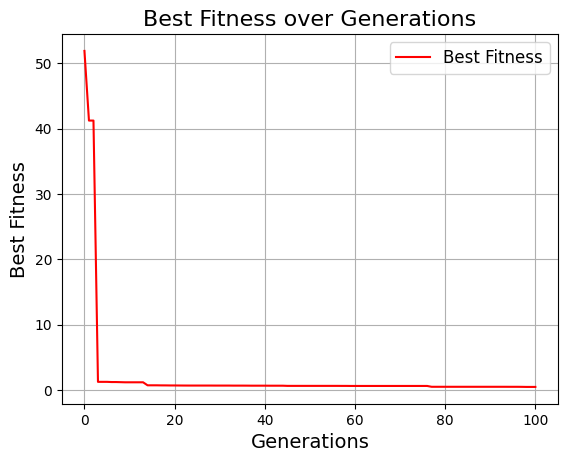

In [15]:
# Extract generations and minimum fitness values
generations = logbook.select("gen")
min_fitness_values = logbook.select("min")

# Plot best fitness over generations
plt.plot(generations, min_fitness_values, color='red', label="Best Fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.grid(True)
plt.show()